In [1]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"


In [2]:
# 検索ツールの定義
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [3]:
tool.invoke("Langgraphのノードとは？")

[{'url': 'https://www.ibm.com/think/topics/langgraph',
  'content': 'Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. Nodes can be thought of as “actors” that interact with each other in a specific way. For example, to add nodes for tool calling, one can use the ToolNode. Another example, the next node, refers to the node that will be executed following the current one.\n\nEdges: Edges are a function within Python that determines which node to execute next based on the current state. Edges can be conditional branches or fixed transitions.\n\n#### Tools\n\nRAG: Retrieval-augmented generation (RAG) combines the power of LLMs with contextual information from external sources by retrieving relevant documents, which are then used as input for answer generation. [...] Workflows: Workflows are the sequences of node interactions that define an AI workflow. By arranging nodes into a workflow, users can create more complex and dynamic workflows that use

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# Stateクラスの定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

# グラフのインスタンスを作成
graph_builder = StateGraph(State)

# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# 変更点：ツール定義の紐づけ
llm_with_tools = llm.bind_tools(tools)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

In [5]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ツールノードの作成
tool_node = ToolNode(tools)

# グラフにツールノードを追加
graph_builder.add_node("tools", tool_node)

# 条件付エッジの作成
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # ツール呼出と判断したらツールノードを呼ぶ
)

# ツールが呼び出されるたびに、チャットボットに戻って次のステップを決定
# ツールからチャットボットへの戻りエッジを作成
graph_builder.add_edge("tools", "chatbot")

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")

# 記憶を持つ実行可能なステートグラフの作成
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

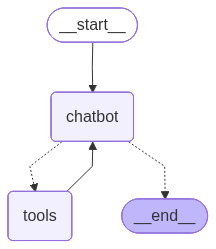

In [6]:
# グラフの可視化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)

こんにちは！
こんにちは！今日はどんなことをお手伝いできますか？
1足す2は？
1足す2は3です。何か他に知りたいことがありますか？
1メートル以上の魚は？

[{"url": "https://tsurihack.com/8448", "content": "## 鯉｜もっとも手軽で簡単な大物\n\n身近な大物コイ  \n難易度：★☆☆｜平均70cm、1m超えれば超絶レア  \n魚釣り初心者の方にオススメしたいのは食パンを使ったコイ釣りです！\n\n身近な大物コイ\n\n安・近・短で手軽に釣ることができ、ボウズ（釣果ゼロ）で終わってしまうリスクも少ないのがパンコイゲームの魅力ですね。\n\n▼食パンを使ったコイの釣り方はこちら！  \n\n針と餌だけのカンタン仕掛けで巨大魚が釣れる！？“パン鯉”に子供と挑戦してみました\n\n2023/04/27釣り好き！まっちゃん\n\n針と餌だけのカンタン仕掛けで巨大魚が釣れる！？“パン鯉”に子供と挑戦してみました\n\n2023/04/27釣り好き！まっちゃん\n\n### 1mを超えるコイは超絶レアですよ！\n\nメーターオーバーの鯉\n\nメーターオーバーの鯉\n\n身近な川魚のコイといえども最大サイズは1ｍを優に超え、コイを専門に狙う釣り人にとってメーター超えの巨鯉は一生に1匹でも良いから釣ってみたい憧れのサイズです。\n\nメーターオーバーのコイは幻級の魚ですが、90cm前後までのコイは都市型河川でもよく見かけますので、パンコイゲームを楽しみに行かれる際は、メジャーも一緒に持って行ってみてはいかがでしょうか。\n\nダイワ \n\nフィッシングメジャーR 150cm\n\n## ウツボ｜岩礁帯にある堤防が狙い目\n\n身近な大物ウツボ\n\n身近な大物ウツボ\n\n難易度：★☆☆｜平均70cm、意外と旨い！\n\n堤防釣りに出掛ける方にオススメなのが、海のギャングとも呼ばれる「ウツボ」を狙った釣り。想像以上に強烈なファイトが味わえますし、冬場はとっても美味しい魚なんです。\n\n関東にお住まいの方なら、房総・三浦・伊豆半島のいずれでもウツボを狙って釣ることができますよ！　関西なら、紀伊半島まで行くとウツボの魚影が濃くなります。 [...] ステンレスフィッシング プライヤー\n\n### 冬のウツボをぜひ味わってみて